# Filtering and retrievals on raw Swiss C-band data

In this exercice we will load raw unfiltered Swiss C-band data during a thunderstorm event and process it to ultimately estimate the precipitation intensities. The following topics will be tackled.

- Ground clutter detection
- Attenuation correction
- KDP estimation
- Hydrometeor classification
- QPE


In [3]:
# Imports

import numpy as np
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt

import pyart
pyart.config.load_config('mch_config.py')


Note that you can create your own Py-ART configuration file, which defines default field names, default colormaps, limits, and much more. This is the one we use at MeteoSwiss. You can then either load it at startup in your python code or define the environment variable PYART_CONFIG to point to your file in your work environment.

Let's start by loading our radar file which is of the standard CFRadial type. It corresponds to the third sweep of the operational radar scans, which is a PPI at 1° elevation. It contains raw radar data (before pre-processing) at a resolution of 83 m. We then add the temperature obtained from the COSMO NWP model to our radar object (note that this temperature was previously interpolated from the model grid to the radar polar grid). Note that the freezing level is quite high in this example (around 4200 m.).

In [4]:
# Open radar file
file_radar = './data/exercice1_swiss_thunderstorm/MHL2217907250U.003.nc'
radar = pyart.io.read_cfradial(file_radar)

# Add temperature
temp = pyart.io.read_cfradial('./data/exercice1_swiss_thunderstorm/20220628073500_savevol_COSMO_LOOKUP_TEMP.nc')
radar.add_field('temperature', temp.fields['temperature'])


Py-ART uses gatefilters which are a kind of mask to filter out problematic measurements. Most processing routines can take a gatefilter as input and will ignore pixels that were filtered out. 

Here we create a gate __[filter](https://arm-doe.github.io/pyart/API/generated/pyart.filters.moment_and_texture_based_gate_filter.html)__ based on the radar moments and their texture to filter out noise and ground clutter. Since we are interested in a strong thunderstorm we also extend this filter to remove all measurements with a SNR ratio of less than 10 dB.



In [5]:
gtfilter = pyart.filters.moment_and_texture_based_gate_filter(radar)
gtfilter.exclude_below('signal_to_noise_ratio', 10)

Let's compare visually the reflectivity before and after filtering. Note that the plot function of Py-ART take a gatefilter as input. 

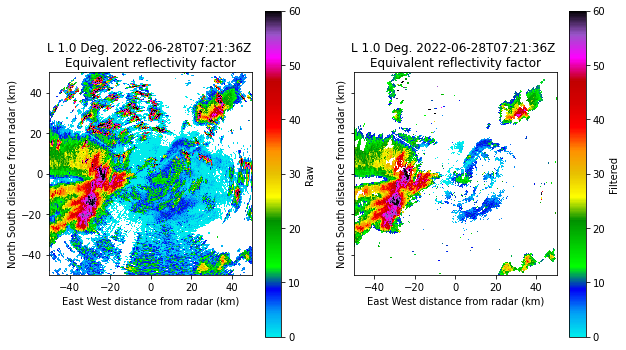

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,6), sharex= True, sharey=True)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('reflectivity', 0, vmin=0, vmax=60., ax = ax[0], colorbar_label = 'Raw')
display.plot_ppi('reflectivity', 0, vmin=0, vmax=60., gatefilter = gtfilter, 
                 ax = ax[1], colorbar_label = 'Filtered')
ax[0].set_xlim([-50,50])
ax[0].set_ylim([-50,50])
ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')

Here it is clear that most ground clutter (mostly north west and east of the radar), as well as noise have been filtered out.

We can expect strong attenuation behind a thunderstorm like this. So it is a good idea to try to correct for it. Knowledge of the specific attenuation can also be very insightful.

In [7]:
out = pyart.correct.calculate_attenuation_zphi(radar, fzl = 4200,
                           gatefilter=gtfilter,
                           phidp_field = 'uncorrected_differential_phase',
                           temp_field = 'temperature',
                           temp_ref = 'temperature')
spec_at, pia, cor_z, spec_diff_at, pida, cor_zdr = out
radar.add_field('corrected_reflectivity', cor_z)
radar.add_field('corrected_differential_reflectivity', cor_zdr)
radar.add_field('specific_attenuation', spec_at)


Here we use the Z-PHI method, which uses the relation between differential phase shift and specific attenuation. However it works only in the liquid phase. So you need to provide it either with a fixed freezing level height, a field of freezing level heights or a field of temperature. Here we provide the later.

This method provides us with 5 output variables
- specific attenuation dB/km
- path integrated attenuation dB
- corrected reflectivity dBZ
- differential specific attenuation dB
- path integrated differential attenuation dB
- corrected differential reflectivity (ZDR) dB

We will now plot the specific attenuation as well as the raw and corrected reflectivities.

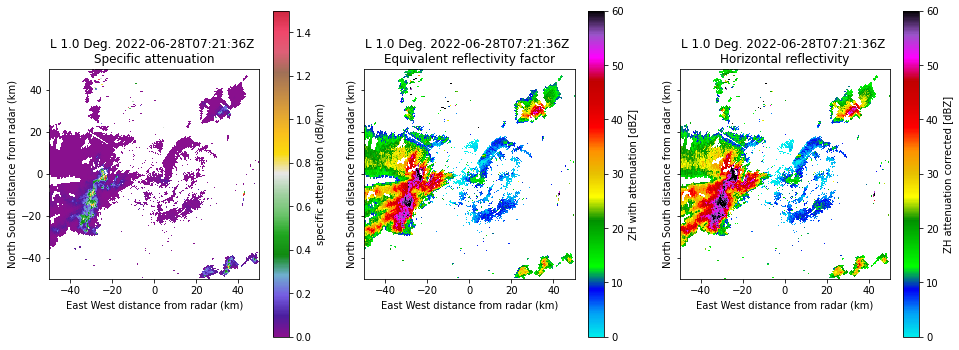

In [8]:
fig, ax = plt.subplots(1,3, figsize=(16,6), sharex= True, sharey=True)
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('specific_attenuation', 0, vmin=0, vmax=1.5, gatefilter = gtfilter,
                     ax = ax[0])
display.plot_ppi('reflectivity', 0, vmin=0, vmax=60., ax = ax[1],  gatefilter = gtfilter,
                 colorbar_label = 'ZH with attenuation [dBZ]')
display.plot_ppi('corrected_reflectivity', 0, vmin=0, vmax=60., gatefilter = gtfilter,
                     ax = ax[2], colorbar_label = 'ZH attenuation corrected [dBZ]')
ax[0].set_xlim([-50,50])
ax[0].set_ylim([-50,50])
ax[0].set_aspect('equal', 'box')
ax[1].set_aspect('equal', 'box')
ax[2].set_aspect('equal', 'box')

We can clearly observe a strong specific attenuation within the thunderstorm as well as a significant difference in reflectivity before/after correction behind the thunderstorm to the west.

Another very interesting radar variable is the specific differential phase shift KDP. Large KDP indicates the presence of large oblate drops and is linked to very strong precipitation. KDP is also needed for the hydrometeor classification algorithm. However KDP is not measured directly and needs to be estimated numerically from the raw differential phase shift (PHIDP). Py-ART provides three different retrieval methods. We will use the method by __[Maesaka et al. (2012)](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.kdp_maesaka.html)__ which is fast and robust but assumes KDP to be positive and is therefore limited to rainfall below the melting layer and/or warm clouds. 

/home/daniel/anaconda3/envs/pyart_arm/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


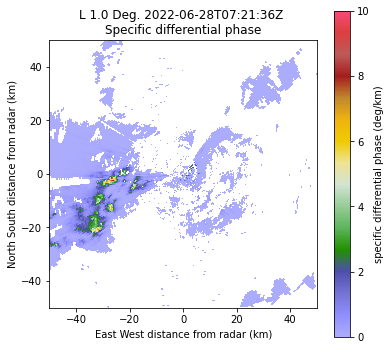

In [9]:
kdp, _, _ = pyart.retrieve.kdp_maesaka(radar, gatefilter = gtfilter,
                                       psidp_field = 'uncorrected_differential_phase')
radar.add_field('specific_differential_phase', kdp)

fig, ax = plt.subplots(1,1, figsize=(6,6))
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('specific_differential_phase', 0, vmin = 0, vmax = 10,
                 ax = ax,  gatefilter = gtfilter)

ax.set_xlim([-50,50])
ax.set_ylim([-50,50])
ax.set_aspect('equal', 'box')

A look at the KDP field shows clusters of very large KDP (> 5 °/km) at the center of the thunderstorm.

The hydrometeor classification algorithm in Py-ART by __[Besic et al. (2016)](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.kdp_maesaka.html)__ uses ZH, ZDR, RHOHV, KDP and the temperature to classify hydrometeors into one of 8 classes:
- Ice hail, high density Graupel
- Melting hail
- Wet snow
- Vertically oriented ice
- Rain
- Rimed particles
- Light rain
- Crystals
- Aggregates

This algorithm requires centroids of polarimetric variables for the different hydrometeor classes. Below we provide it with centroids specifically suited for the radar of Monte Lema. If left empty, the algorithm will use default centroids at the right frequency band (X, C or S).


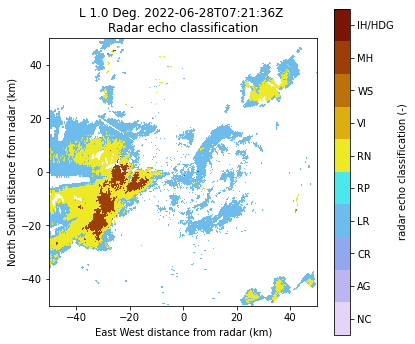

In [10]:
centroids = np.array([[13.8231,0.2514,0.0644,0.9861,1380.6],
[3.0239,0.1971,0.,0.9661,1464.1],
[4.9447,0.1142,0.,0.9787,-974.7],
[34.2450,0.5540,0.1459,0.9937,945.3],
[40.9432,1.0110,0.5141,0.9928,-993.5],
[3.5202,-0.3498,0.,0.9746,843.2],
[32.5287,0.9751,0.2640,0.9804,-55.5],
[52.6547,2.7054,2.5101,0.9765,-1114.6],
[46.4998,0.1978,0.6431,0.9845,1010.1]])


hydro = pyart.retrieve.hydroclass_semisupervised(radar, mass_centers = centroids,
                                 refl_field =  'corrected_reflectivity',
                                 zdr_field = 'corrected_differential_reflectivity',
                                 kdp_field = 'specific_differential_phase',
                                 rhv_field = 'uncorrected_cross_correlation_ratio',
                                 temp_field = 'temperature')

radar.add_field('radar_echo_classification', hydro)

fig, ax = plt.subplots(1,1, figsize=(6,6))
display = pyart.graph.RadarDisplay(radar)
import matplotlib as mpl

labels = ['NC','AG', 'CR', 'LR', 'RP', 'RN', 'VI', 'WS', 'MH', 'IH/HDG']
ticks = np.arange(len(labels))
boundaries = np.arange(-0.5, len(labels) )
norm = mpl.colors.BoundaryNorm(boundaries, 256)

cax = display.plot_ppi('radar_echo_classification', 0, ax = ax,  gatefilter = gtfilter,
                 norm = norm, ticks = ticks, ticklabs = labels)

ax.set_xlim([-50,50])
ax.set_ylim([-50,50])
ax.set_aspect('equal', 'box')

Note that the plotting commands are slightly more complicated due to the categorical colormap.

A look at the hydrometeor classification reveals the presence of wet hail in the center of the thunderstorm surrounded by rain and by light rain. A few isolated pixels (unfiltered ground clutter) are also classified as hail. 
There was indeed intense hail at the ground on that day.

Py-ART provides several QPE algorithms but the most refined relies on the hydrometeor classification and uses different relations between radar variables and precipitation intensities within the different hydrometeor classes.

In [11]:
qpe = pyart.retrieve.est_rain_rate_hydro(radar, refl_field = 'corrected_reflectivity',
                                         hydro_field = 'radar_echo_classification',
                                         a_field = 'specific_attenuation',
                                         thresh=40)

radar.add_field('radar_estimated_rain_rate', qpe)


We will now plot the precipitation intensity on a Cartopy map and add some spatial features (land borders) using __[RadarMapDisplay](https://arm-doe.github.io/pyart/API/generated/pyart.graph.GridMapDisplay.html)__

/home/daniel/anaconda3/envs/pyart_arm/lib/python3.9/site-packages/cartopy/crs.py:2320: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.float(self.globe.semimajor_axis or WGS84_SEMIMAJOR_AXIS)
/home/daniel/anaconda3/envs/pyart_arm/lib/python3.9/site-packages/cartopy/crs.py:2321: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.flo

> /home/daniel/anaconda3/envs/pyart_arm/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py(1606)_pcolormesh_patched()
   1604         coords = np.column_stack((X.flat, Y.flat)).astype(float, copy=False)
   1605         import pdb; pdb.set_trace()
-> 1606         collection = mcoll.QuadMesh(
   1607             Nx - 1, Ny - 1, coords,
   1608             antialiased=antialiased, shading=shading, **kwargs)

ipdb> c


/home/daniel/anaconda3/envs/pyart_arm/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1606: MatplotlibDeprecationWarning: This usage of Quadmesh is deprecated: Parameters meshWidth and meshHeights will be removed; coordinates must be 2D; all parameters except coordinates will be keyword-only.
  collection = mcoll.QuadMesh(


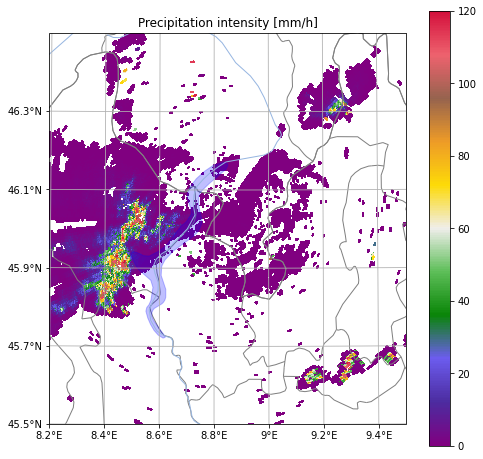

In [20]:
lon_bnds = [8.2, 9.5]
lat_bnds = [45.5, 46.5]

display = pyart.graph.RadarMapDisplay(radar)

fig = plt.figure(figsize=(8,8))
display.plot_ppi_map('radar_estimated_rain_rate', 0, vmin=0, vmax=120.,
          colorbar_label='', title='Precipitation intensity [mm/h]', gatefilter = gtfilter,
          min_lon = lon_bnds[0], max_lon = lon_bnds[1],mask_outside = True,
          min_lat = lat_bnds[0], max_lat = lat_bnds[1],
          lon_lines=np.arange(lon_bnds[0], lon_bnds[1], .2), resolution='10m',
          lat_lines=np.arange(lat_bnds[0], lat_bnds[1], .2),
          lat_0=radar.latitude['data'][0],
          lon_0=radar.longitude['data'][0], embellish=True)

states_provinces = cartopy.feature.NaturalEarthFeature(
                category='cultural',
                name='admin_0_countries',
                scale='10m',
                facecolor='none')
lakes = cartopy.feature.NaturalEarthFeature(
                category='physical',
                name='lakes',
                scale='10m',
                facecolor='blue')
rivers = cartopy.feature.NaturalEarthFeature(
                category='physical',
                name='rivers',
                scale='10m',
                facecolor='blue')
display.ax.add_feature(states_provinces, edgecolor='gray')
display.ax.add_feature(lakes, edgecolor='blue', alpha = 0.25)
display.ax.add_feature(cartopy.feature.RIVERS)



Note that we didn't estimate precipitation intensity at the ground but only aloft. Within the thunderstorm precipitation intensity is extremely high. This is likely too high because QPE in wet hail is very uncertain. However, even the operational QPE algorithm at MeteoSwiss estimated precipitation intensities at the ground close to 120 mm/h. 